In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# ptyLab introduction
"ptyLab" is a highly modular coding package which can be used for both conventional and Fourier ptychography reconstruction. Due to the modular nature it is easy to modify the code for various tasks and add your own functions, such as a new reconstruction engine or a calibration routine. To understand ptychoLab we need to understand the basic classes contained within, which are briefly outlined below:

 -  DefaultExperimentalData - this class is used to import the experimental data from an .hdf5 file. If file contains the experimental images stored as an image stack (called ptychogram), probe/LED positions and several experimental parameters then the data can be successfully imported and reconstructed.
 -  Optimizable - this class creates various objects from the immutable experimentalData class which will be optimized i.e. are mutable. 
 -  ReconstructionParameters - this class stores parameters use for the reconstruction such that they could be exported/imported for different experiments
 -  Engines - all the engines used for the reconstruction are based on this class, which take the experimentalData and Optimizer objects as parameters and perform object/probe reconstruction.
 -  Monitor - visualization class used to display the reconstruction process
 
Each class can be manipuplation and has a range of parameters. However, it is possible to circumvent the initialization process by calling fracPy.easy_initialize() function in fracPy. It takes 3 parameters as input: (filePath, engine, operationMode). 

Below is "embarrassingly simple" Fourier ptychography reconstruction process.

In [2]:
from fracPy.io import getExampleDataFolder
import fracPy

# fileName = 'LungCarcinomaFPM.hdf5'
fileName = 'LungCarcinomaSmallFPM.hdf5'
filePath = getExampleDataFolder() / fileName

optimizable, exampleData, params, monitor, engine, calib = fracPy.easy_initialize(filePath, operationMode='FPM')
params.gpuSwitch = True

%matplotlib notebook
engine.doReconstruction()
%matplotlib inline

C:\fracPty\fracPy\Engines\BaseReconstructor.py:284: UserWarning: fftshiftSwitch set to false, this may lead to reduced performance
  warnings.warn('fftshiftSwitch set to false, this may lead to reduced performance')


<IPython.core.display.Javascript object>

ePIE: 100%|████████████████████████████████████████████████████████████████████████████| 50/50 [00:22<00:00,  2.24it/s]


## ExperimentalData class
The data must be stored as a ".hdf5" file, which convieniently enables structured file storage. For ptychographic data, experimental parameters such as wavelenght or pixel size can be convieniently stored together with illumination positions and the actual raw images in a single file.

Full list of fields required for ptyLab to work are:
- ptychogram - 3D image stack 
- wavelength - illumination lambda
- encoder - diffracted field positions
- dxd - pixel size
- zo - exit wave propagation  distance (sample-to-detector distance in CP and sample-to-lens distance in FP)

Also we have optional fields because they will either be computed later from the "required_fields" or are required for FPM, but not CPM (or vice-versa). If not provided by the user they will be set as None.
- magnification - magnification, used for FPM computations of dxp
- dxp - can be provided by the user (otherwise will be computed using dxp=dxd/magnification for FPM)
- No -  number of upsampled pixels
- Nd -  probe/pupil plane size, will be set to Ptychogram size by default
- entrancePupilDiameter -  entrance pupil diameter, defined in lens-based microscopes as the aperture diameter, required for FPM
- spectralDensity -  CPM parameter multi wavelength reconsruction
- zled - LED to sample distance
- theta - tilt angle for reflection mode CP

Apart from 1D experimental parameter values (NOTE: defined in meters!) there are other two important fields.

The ".hdf5" file must contain a field called "ptychogram" containing the experimental raw images as a 3D array of shape [N,X,Y], where N is the number of images corresponding to each illumination vector in the "encoder" and X-Y are the 2D image dimensions. 

The ".hdf5" file must have a field called "encoder" containing the positions of the illumination in meters and has a 2D shape [N,2], where N is the number of illumination positions used on a X-Y grid.

ExperimentalData() takes filename of the .hdf5 file as input. In this example the varible "exampleData" will contain our class.


In [3]:
mean_img = np.mean(exampleData.ptychogram,0)

## Optimizable class
The ExperimentalData class contains immutable values. The Optimizable class creates object which will be mutable during the reconstruction or calibration procedure. These objects will be the reconstructed object and the probe/pupil. We can use switches to determine how the data should be prepared for the reconstruction. Once everything is set use "prepare_reconstruction()" method.

In FPM the intial object estimate can be computed from the raw data. "Optimizable.initialObject = 'upsampled' will take the low-resolution raw data and create an upsampled object estimate via interpolation. The probe/pupil is set to be a clear circle representing a fully transparent aperture without any aberration.

To use the illumination locations for data reconstruction they must be converted from SI units into pixels in the Fourier domain. The converted physical probe/LED positions can be accessed from our "Optimizable" class via the field "positions" which in our example is invoked via "optimizable.positions". Each time the command "optimizable.positions" is used called "positions" are computed on the fly rather than being pre-computed during data import. They are computed from the experimentalData.encoder field, where the encoder stores physical probe/LED positions. The reason for this is that ptychoLab contains several routines such as "zPIE" or "LED calibration" where the actual physical experimental positions inside the "encoder" field can be corrected in the presence of experimental errors. Hence, "optimizable.positions" will immediately return Fourier space positions in pixels with the corrections applied, which enables, for example, iterative position updating during the image reconstruction. This is useful for the "zPIE" method used in ptychography where the sample-to-detector distance is adjusted iteratively.

The optimizable parameters can be changed in the following way. Once parameters are defined use "prepare_reconstruction()" function to construct various initialization object (probe, object etc.)

In [4]:
optimizable.initialProbe = 'circ'
optimizable.initialObject = 'upsampled'
optimizable.prepare_reconstruction()

## Reconstruction_parameters class
This class holds the parameters to be used on the optimizable objects. Example of common parameters used for FPM is shown below 

In [5]:
params.gpuSwitch = True
params.positionOrder = 'NA'
params.probeBoundary = True
params.adaptiveDenoisingSwitch = True

## Monitor class
This class will create a monitor to visualize the reconstruction. 

In [6]:
# Set monitor properties
monitor.figureUpdateFrequency = 10
monitor.objectPlot = 'complex'  
monitor.verboseLevel = 'low'
monitor.objectPlotZoom = .01 
monitor.probePlotZoom = .01 

## IlluminationCalibration class
The reconstruction above shows a displaced probe/pupil which tries to account for lateral LED array shift. If the reconstructor shifts the probe, then it is an indicator that there are some model mismatch errors. Fortunately, translational errors can be corrected by shifting the pupil, which fortunately happens in this case due to the self-healing nature of the algorithm (in some cases you can see the reconstructed pupil being off-center). 

If the errors are large there will be visible artefacts affecting the results. The misplaced LED array errors cause  "exampleData.positions" to not represent the actual data. Fortunately, the calibrator class can be used to do the corrections. In this case we will assume translational errors i.e. the LED array was displaced laterally with respect to the sample defined by "calib.fit_mode = 'SimilarityTransform'" switch. Use the runCalibration() method to perform position calibration.

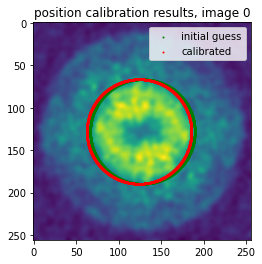

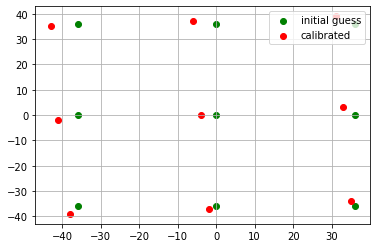

<SimilarityTransform(matrix=
    [[ 1.02681992,  0.06321839,  0.29310345],
     [-0.06321839,  1.02681992, -3.94827586],
     [ 0.        ,  0.        ,  1.        ]]) at 0x17450f6b508>

In [7]:
calib.plot = True
calib.fit_mode ='SimilarityTransform'
calib.runCalibration()

## Engine class
A specific engine can be imported (e.g. ePIE, mPIE etc.) and used on the optimizable class to "optimize" our initial estimates for the object/probe. In this example we use the quasi-Newton method to reconstruct the data, by passing the optimizable, exampleData and monitor objects to be used during the reconstruction.

To use any engine from ptyLab, we can import the class Engines() and create a new reconstruction engine. Let's try reconstructing our calibrated dataset with a quasi-Newton engine instead of ePIE.

C:\fracPty\fracPy\Engines\BaseReconstructor.py:284: UserWarning: fftshiftSwitch set to false, this may lead to reduced performance
  warnings.warn('fftshiftSwitch set to false, this may lead to reduced performance')


<IPython.core.display.Javascript object>


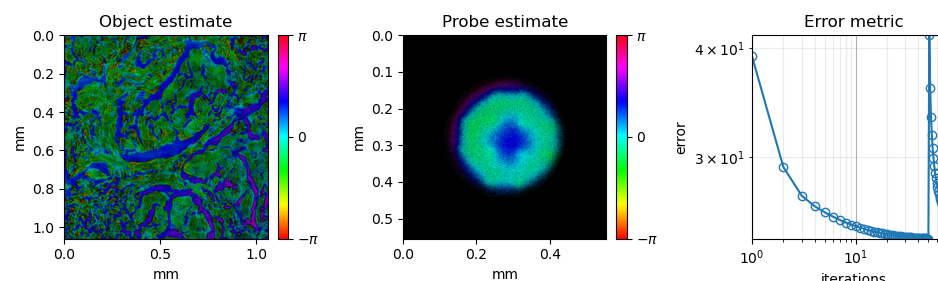

Momentum Engines implemented: momentum, ADAM, NADAM
Momentum engine used: ADAM
mqNewton: 100%|████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.87it/s]


In [8]:
from fracPy import Engines
engine = Engines.mqNewton(optimizable, exampleData, params, monitor)

%matplotlib notebook
engine.doReconstruction()
%matplotlib inline

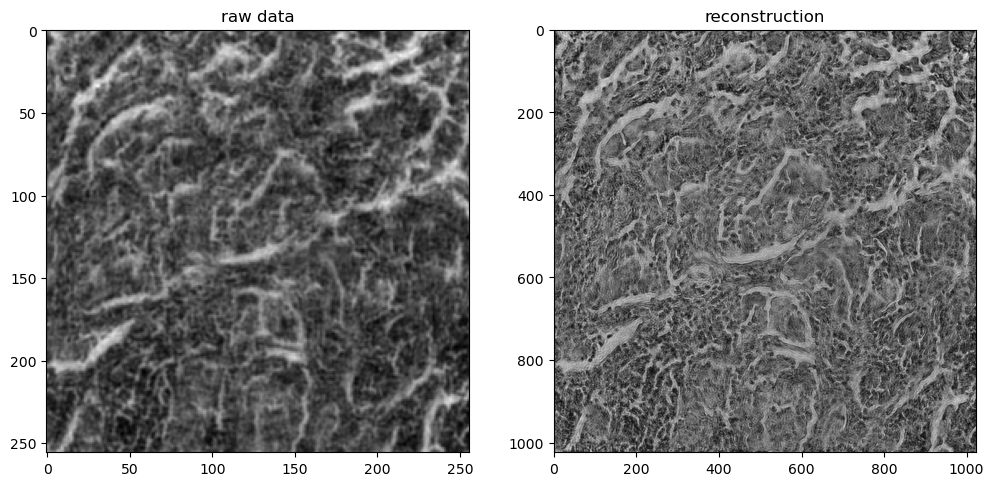

In [19]:
from fracPy.utils.utils import fft2c
from fracPy.utils.visualisation import modeTile
plt.rcParams['figure.figsize'] = [12, 12]
plt.rcParams['figure.dpi'] = 100 

plt.subplot(121)
plt.title('raw data')
plt.imshow(abs(mean_img),cmap='gray')
plt.subplot(122)
plt.title('reconstruction')
plt.imshow(abs(modeTile(fft2c(optimizable.object))),cmap='gray')